In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/Development/Biometrics/fingerprint'

/content/drive/My Drive/Development/Biometrics/fingerprint


# Fingerprint Recognition

In [3]:
import cv2 # OpenCV
import numpy as np # Array processing
import matplotlib.pyplot as plt # Plotting
%matplotlib inline
from pathlib import Path # File path processing
import fprmodules.enhancement as fe # Fingerprint enhancement
from sklearn.metrics import roc_curve
import pickle # Save and read intermediate results
from tqdm.notebook import tqdm as tqdm_notebook # Visual progress bar
from IPython.display import clear_output
try:
  import pyeer
except ImportError as e:
  !pip install pyeer
  import pyeer # Simple biometric metrics
  # Install opencv-contrib if SIFT/SURF is being used.
  !pip uninstall opencv-python
  !pip uninstall opencv-contrib-python
  !pip install opencv-python==3.4.2.16
  !pip install opencv-contrib-python==3.4.2.16
  clear_output()
import seaborn as sns
sns.set(style="dark")
from IPython.core.display import HTML
def center_plots(horizontal=False):
  display(HTML("""
  <style>
  #output-body {
    display: flex;
    flex-direction: """ + ('row' if horizontal else 'column') + """;
    align-items: center;
    justify-content: center;
  }
  </style>
  """))
import os.path

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Reading image data and conversion to gray scale

In [0]:
def read_database(path):
    """
    Read a whole database, stored in a single folder with filenames as 
      XXY.tif with XX the individual number and Y the fingerprint number 
      for this individual returns a list of images and a list of associated 
      identity labels.
    """
    images = []
    labels = []
    imagePaths = sorted(Path(path).rglob("*.tif"))
    for imagePath in tqdm_notebook(imagePaths):
        image = cv2.imread(path + imagePath.name)
        if (len(image.shape) > 2):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rows,cols = np.shape(image);
        aspect_ratio = np.double(rows) / np.double(cols);
        new_rows = 350; # randomly selected number
        new_cols = new_rows / aspect_ratio;
        image = cv2.resize(image, (np.int(new_cols), np.int(new_rows)));
        images.append(image)
        label = imagePath.stem[1:3]
        labels.append(label)
    return (images, labels)


(350, 363)


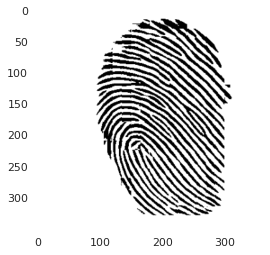

In [5]:
# Load dataset
selected_database = 1 # select database here
images, labels = read_database('./fprdata/FVC2002/DB' + str(selected_database) + '_B/')

# Verify through visualisation
print(images[0].shape)
plt.imshow(images[0],cmap='gray')
plt.show()

### Preprocessing: enhancement using ridge orientation/frequency estimation and segmentation of foreground

*There was some bug with the aspect ratio being set wrong which led to poor segmentation or enhancement in some cases. This was fixed, normally all images should be fine.*

In [0]:
def enhance_images(images):
    """
    Enhance the given images and determine their segmentation masks.
    """
    images_e_u = []
    orientations = []
    frequencies = []
    masks = []
    for i, image in enumerate(tqdm_notebook(images)):
        try:
            img_e, mask, orientim, freqim = fe.image_enhance(image) # Gabor filtering
            img_e_u = cv2.normalize(img_e, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0) # normalize in [0,255] range
            images_e_u.append(img_e_u)
        except:
            print('An error occured for image: ', i)
            images_e_u.append(image)
        masks.append(mask)
        orientations.append(orientim)
        frequencies.append(freqim)
    return images_e_u, orientations, frequencies, masks

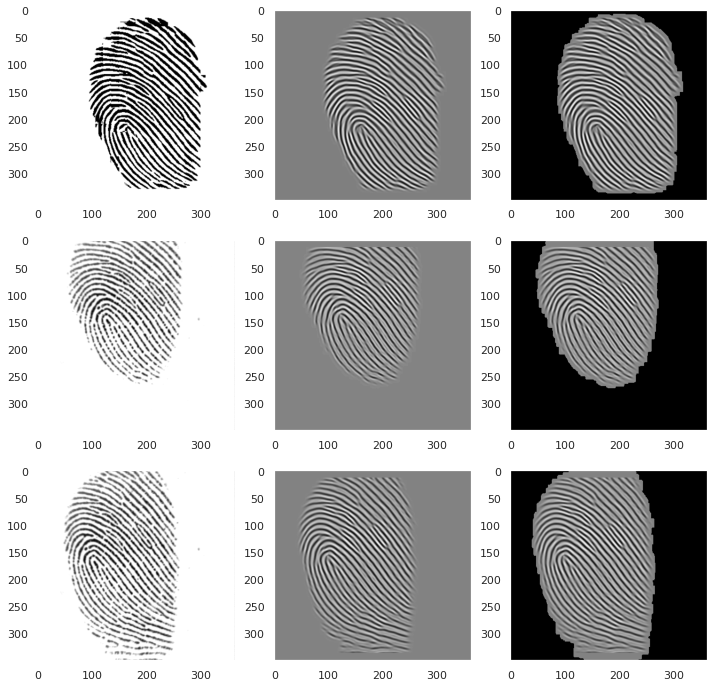

In [7]:
# Fetch or calculate enhanced images and masks
enhanced_images_path = './fprdata/DB' + str(selected_database) + '_enhanced.p'
if os.path.isfile(enhanced_images_path):
  saved_pickle_file = open(enhanced_images_path, 'rb')
  [images_enhanced, orientations, frequencies, labels, masks] = pickle.load(saved_pickle_file)
else:
  images_enhanced, orientations, frequencies, masks = enhance_images(images)
  tosave_pickle_file = open(enhanced_images_path, 'wb')
  pickle.dump([images_enhanced, orientations, frequencies, labels, masks], tosave_pickle_file)

# Visualise them (sanity check)
center_plots()
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(12,12))
for i in range(3):
  ax[i,0].imshow(images[i], cmap='gray')
  ax[i,1].imshow(images_enhanced[i], cmap='gray')
  ax[i,2].imshow(images_enhanced[i] * masks[i], cmap='gray')
plt.show()

### Keypoint Extraction and matching

#### Keypoint detection and feature description

In [0]:
def detect_keypoints(image, detector_name):
    """
    Detect keypoints in the given image and describe them.
    The detector (/descriptor) strategy with given name is used.
    """
    max_results = 800
    if detector_name == 'SIFT':
      dd = cv2.xfeatures2d.SIFT_create(max_results, contrastThreshold=0.02, edgeThreshold=20)
    elif detector_name == 'SURF':
      dd = cv2.xfeatures2d.SURF_create(max_results)
    #elif descriptor_name == 'FAST':
      #cv2.FastFeatureDetector_create()
    elif detector_name == 'BRIEF':
      #detector = cv2.xfeatures2d.StarDetector_create()
      detector = cv2.ORB_create(max_results)
      brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
      kp = detector.detect(image, None)
      return brief.compute(image, kp)
    elif detector_name == 'BRISK':
      dd = cv2.BRISK_create();
    else:
      dd = cv2.ORB_create(max_results)
    return dd.detectAndCompute(image, None)

def get_norm(detector_name):
  """
  Get the norm associated to the given detector.
  """
  return cv2.NORM_L2 if detector_name == 'SIFT' or detector_name == 'SURF' else cv2.NORM_HAMMING

In [0]:
# Pick a detector/descriptor.
detector_name = 'SURF' # ORB | SIFT | SURF | BRISK | BRIEF
detector_norm = get_norm(detector_name)

In [0]:
def remove_edge_kps(mask, kp, desc):
    """
    This procedure removes keypoints at the edges.
    Many false keypoints will be generated at the edge of the 
      foreground mask, since ridges seem to terminate due to the clipping.
    We remove these by a morpholigical erosion (shrinking) 
      of the foreground mask and deleting the keypoints outside.
    """
    mask_b = mask.astype(np.uint8)  #convert to an unsigned byte
    # morphological erosion
    mask_b *= 255
    mask_e = cv2.erode(mask_b, kernel = np.ones((5,5),np.uint8), iterations = 5)
    # remove keypoints and their descriptors that lie outside this 
    #   eroded mask
    kpn = [kp[i] 
            for i in range(len(kp)) 
            if mask_e.item(int(kp[i].pt[1]), int(kp[i].pt[0])) == 255
    ]
    descn = np.vstack([desc[i] 
                        for i in range(len(kp)) 
                        if mask_e.item(int(kp[i].pt[1]), int(kp[i].pt[0])) == 255
    ])
    return kpn, descn

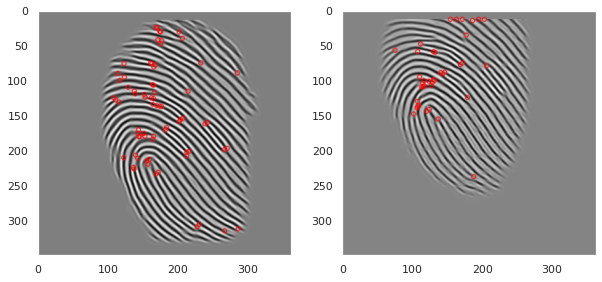

In [11]:
def find_keypoints(image, mask, detector_name):
  """
  Detect keypoints and generate descriptors for the given image.
  This also removes keypoints at the edges (of the given mask).
  """
  kp, des = detect_keypoints(image, detector_name)
  return remove_edge_kps(mask, kp, des)

def draw_keypoints(image, keypoints):
  """
  Draw the given keypoints on the given image.
  """
  return cv2.drawKeypoints(image, keypoints, None, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)

# Find keypoints and generate descriptors (test on two images)
test_nr_1 = 0
test_nr_2 = 1
image_enhanced_1 = images_enhanced[test_nr_1]
image_enhanced_2 = images_enhanced[test_nr_2]
kp1, des1 = find_keypoints(image_enhanced_1, masks[test_nr_1], detector_name)
kp2, des2 = find_keypoints(image_enhanced_2, masks[test_nr_2], detector_name)

# Visualise the keypoints
center_plots()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
ax[0].imshow(draw_keypoints(image_enhanced_1, kp1))
ax[1].imshow(draw_keypoints(image_enhanced_2, kp2))
plt.show()

#### Local matching by feature vector comparison

In [0]:
def match_bruteforce_local(des1, des2, norm=cv2.NORM_HAMMING):
    """
    Returns all pairs of best matches.
    crossCheck=True only retains pairs of keypoints that are each 
      other best matching pair.
    """
    bf = cv2.BFMatcher(norm, crossCheck=True)
    matches = bf.match(des1, des2)
    matches.sort(key=lambda x: x.distance, reverse=False) # sort matches based on feature distance
    return matches

def find_matches(des1, des2, norm=cv2.NORM_HAMMING):
  """
  Find matches for the given sets of descriptors.
  """
  return match_bruteforce_local(des1, des2, norm)

def draw_matches(img1, img2, kp1, kp2, matches):
  """
  Draw the given matches on the given images.
  """
  return cv2.drawMatches(img1, kp1, img2, kp2, matches, None)

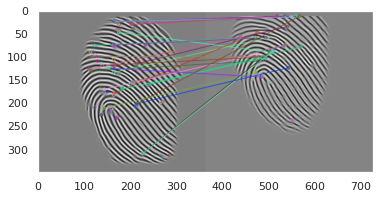

In [13]:
matches = find_matches(des1, des2, detector_norm)

center_plots()
plt.imshow(draw_matches(image_enhanced_1, image_enhanced_2, kp1, kp2, matches))
plt.show()

#### Global matching by testing geometrical consistency

In [0]:
def match_bruteforce_global(kp1, 
                            kp2, 
                            matches, 
                            good_match_percent = 0.75,
                            transform=True):
    """
    Find matches for the given sets of keypoints based on a global (affine) transformation.
    This transformation is approximated with RANSAC.
    """
    # A local function required to transform key_points by a certain 
    #   transformation matrix
    def transform_keypoints(key_points, transformation_matrix):
        # convert keypoint list to Nx1x2 matrix
        mat_points = cv2.KeyPoint.convert(key_points).reshape(-1,1,2)
        # transform points 
        mat_reg_points = cv2.transform(mat_points, transformation_matrix)
        # return transformed keypoint list
        return cv2.KeyPoint.convert(mat_reg_points)    

    # Select the best x percent best matches (on local feature vector 
    #   level) for further global comparison.
    num_good_matches = int(len(matches) * good_match_percent)
    good_matches = matches[:num_good_matches]
   
    # Retain only the keypoints associated to the best matches 
    src_pts = np.float32(
        [kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32(
        [kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Estimate an optimal 2D affine transformation with 4 degrees of 
    #   freedom, limited to combinations of translation, rotation, and 
    #   uniform scaling.
    # This is the core of the global consistency check: if we find the 
    #   correct transformation (which we expect for genuine pairs and 
    #   not for imposter pairs), we can use it as an additional check by 
    #   verifying the geometrical quality of the match.
    
    # M stores the optimal transformation
    # inliers stores the indices of the subset of points that were 
    #   finally used to calculate the optimal transformation.
    # "inliers: Output vector of same length as number of points, 
    #   indicating which points are inliers."
    M, inliers = cv2.estimateAffinePartial2D(src_pts, 
                                             dst_pts, 
                                             method=cv2.RANSAC, 
                                             confidence=0.9, 
                                             ransacReprojThreshold=10.0, 
                                             maxIters=5000, 
                                             refineIters=10)
    
    # Get the inlier matches
    matched = [x for x,y in zip(good_matches, inliers) if y[0] == 1]

    # The optimal transformation is only correct for genuine pairs in 
    #   about 75% of cases (experimentally on dataset DB1).
    # One can build additional checks about the validity of the 
    #   transformation, e.g. too large translations, rotations and/or 
    #   scale factors.
    
    # A simple one is to test the number of keypoints that were used 
    #   in calculating the transformation. 
    # If this number is is too small, then the transformation is 
    #   most possibly unreliable. 
    # In that case, we reset the transformation to the identity.
    if np.sum(inliers) < 5:
        M = np.eye(2, 3, dtype=np.float32)

    return (transform_keypoints(kp1, M) if transform else kp1), matched, M

def visualise_matches_transformation(kp1, kp2, img1, img2, matches, verbose=False):
  """
  Visualisation of matches after affine transformation.
  """
  kp1_reg, matched, M = match_bruteforce_global(kp1, kp2, matches)
  height, width = img2.shape[:2]
  img1_reg = cv2.warpAffine(img1, M, (width, height))
  plt.imshow(draw_matches(img1_reg, img2, kp1_reg, kp2, matched)) # only the inlier matches (matched) are shown.
  plt.show()
  if verbose:
    print("Affine_#inliers:{}".format(len(matched)))
  return img1_reg, kp1_reg

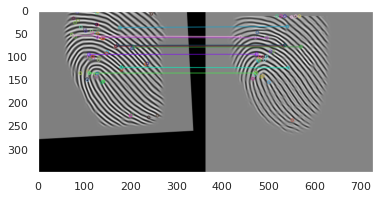

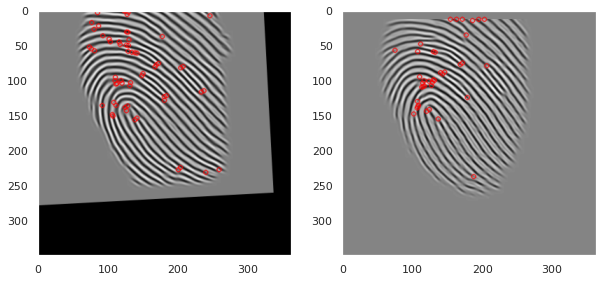

In [15]:
# Note; the hypothesis is that the transformation will be OK most of the 
#   time when it comes to genuine pairs, not for imposter pairs. 
img1_reg, kp1_reg = visualise_matches_transformation(kp1, 
                                                     kp2,
                                                     image_enhanced_1,
                                                     image_enhanced_2,
                                                     matches,
                                                     verbose=False)

# Show all keypoints after geometric matching.
center_plots()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
ax[0].imshow(draw_keypoints(img1_reg, kp1_reg))
ax[1].imshow(draw_keypoints(image_enhanced_2, kp2))
plt.show()

## Tasks

#### Task 1 Test different Keypoint Detectors/Descriptors

* OpenCV provides different KeyPoint detectors and descriptors (ORB, SIFT, SURF, BRIEF, ...). Briefly test, visually, which of these seem to extract relatively reliable interesting points from the fingerprints.
* Note that for some of the KeyPoint descriptors, you need to have a special licence or a full implementation. Skip if you do not have it.
* You also may have to tune the parameters of these detectors.
* But don't spend too much time on this testing step. 
* If you do have the time and the computational resources, you can compare not just visually but by calculating all through using ROC and CMC curves as evidence (Cf. task 3)

ORB :


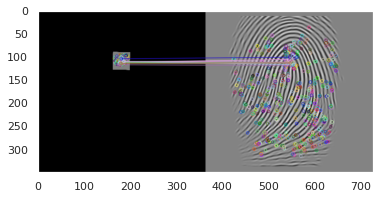

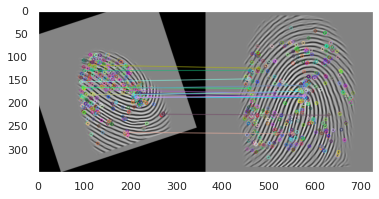

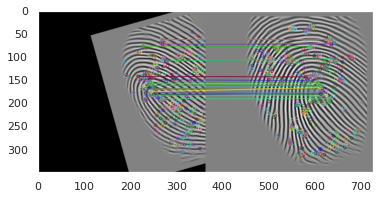

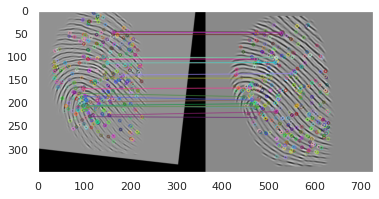

SURF :


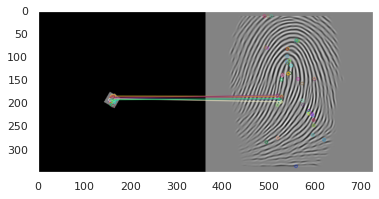

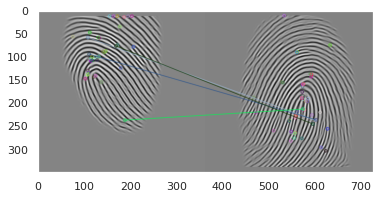

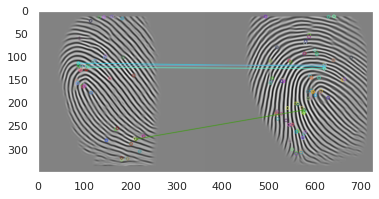

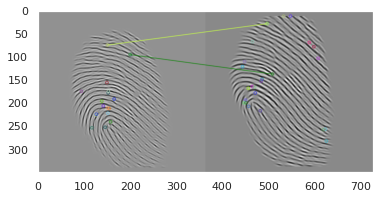

SIFT :


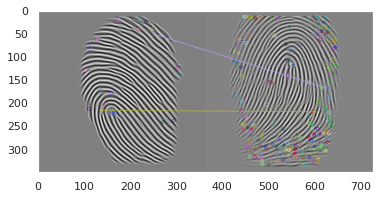

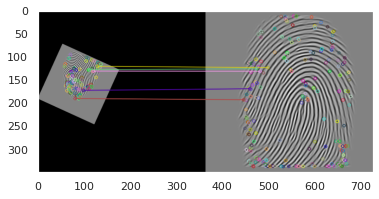

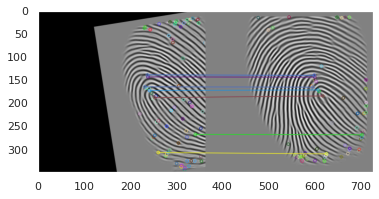

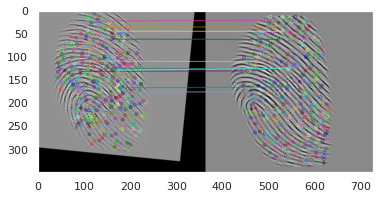

BRIEF :


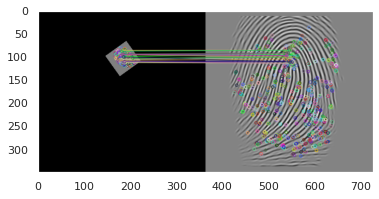

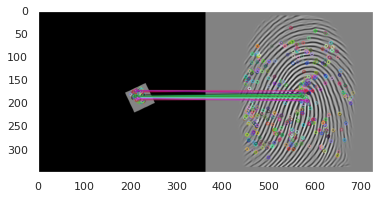

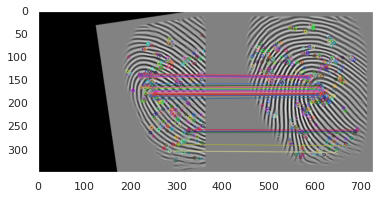

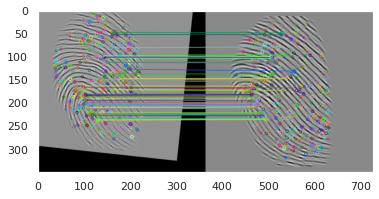

BRISK :


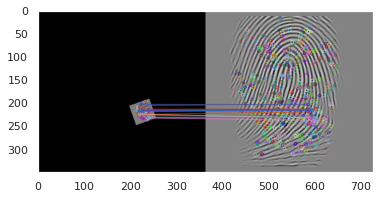

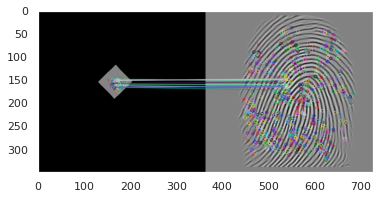

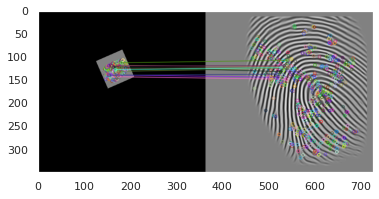

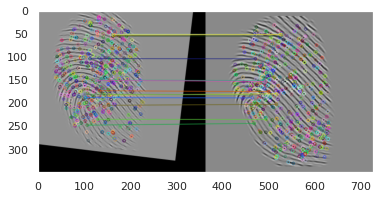

In [16]:
center_plots()
for detector_name in ['ORB', 'SURF', 'SIFT', 'BRIEF', 'BRISK']:
  print(detector_name + ' :')
  for t1, t2 in zip([0,1,2,3], [8,9,6,7]):
    kp1, des1 = find_keypoints(images_enhanced[t1], masks[t1], detector_name)
    kp2, des2 = find_keypoints(images_enhanced[t2], masks[t2], detector_name)
    matches = find_matches(des1, des2, get_norm(detector_name))
    visualise_matches_transformation(kp1, kp2, images_enhanced[t1], images_enhanced[t2], matches, False)

*From this - limited - set of results it looks like ORB, SIFT and BRIEF (using ORB as a detector) are worth experimenting with further. All 3 are  evaluated in what follows.*

*Minutiae look like a safer bet because they deal specifically with fingerprints while the feature descriptors are designed for very broad usage.*

In [0]:
selected_descriptors = ['ORB', 'SIFT', 'BRIEF']

#### Task 2. Determine a matching function
    
You have been given code to calculate matches on a local level and to calculate an affine transformation that allows a more global consistency check. 
    
Define and test different matching functions that make use of these two-level features.
    
1. a function based only on the local features (e.g. number of pairs with feature distance below a set distance threshold, the sum or mean of the feature distance of the best N pairs, or any other function you think is a good candidate)
2. a function based on the geometrical distances between pairs of KeyPoints after affine transformation. For instance, you can take again a brute force matcher that, instead of pairwise feature descriptor distances, computes pairwise geometrical distances between the two point sets. From there on you can then define different measures (number of distances below a threshold or sum/mean of distances, ...). You can also limit the number of point pairs to apply this to to the matching pairs that result from the local match and/or the ones that are returned as 'matched' by the Ransac procedure. 
3. any combination of local and global match metrics

In [0]:
def score_local(matches, nb_matches=10):
  """
  Takes the mean of the first `nb_matches` matches,
    or returns a large number (2^12) if there aren't any.
  """
  matches.sort(key=lambda x: x.distance, reverse=False)
  nb_matches = min(nb_matches, len(matches))
  if nb_matches == 0:
    return 2**12
  nb_selected = min(len(matches),nb_matches)
  return sum(m.distance for m in matches[:nb_selected]) / nb_selected

def score_local2(matches):
  """
  Takes the number of matches with distance smaller than a certain number.
  Keep in mind that distances depend on the norm.
  """
  return sum(m.distance < 75 for m in matches)

def get_score_local(i, j, descriptor, matcher):
  """
  Helper function for getting the local score for two images using the given descriptor / matcher.
  """
  _, des_i = find_keypoints(images[i], masks[i], descriptor)
  _, des_j = find_keypoints(images[j], masks[j], descriptor)
  matches = matcher.match(des_i, des_j)
  return score_local(matches)

In [0]:
def score_global(matches, nb_matches=10):
  """
  Takes the mean of the first `nb_matches` matches,
    or returns a large number (2^12) if there aren't any.
  """
  matches.sort(key=lambda x: x.distance, reverse=False)
  nb_matches = min(nb_matches, len(matches))
  if nb_matches == 0:
    return 2**12
  nb_selected = min(len(matches),nb_matches)
  return sum(m.distance for m in matches[:nb_selected]) / nb_selected

def score_global2(matches):
  """
  Takes the number of matches with distance smaller than 70.
  Keep in mind that distances depend on the norm.
  """
  return sum(m.distance < 120 for m in matches)

def get_score_global(i, j, descriptor, matcher):
  """
  Helper function for getting the global score for two images using the given descriptor / matcher.
  """
  # first get keypoints and descriptors, then match them
  kp_i, des_i = find_keypoints(images[i], masks[i], descriptor)
  kp_j, des_j = find_keypoints(images[j], masks[j], descriptor)
  matches = matcher.match(des_i, des_j)
  # determine a proper affine transformation
  kpi_transformed, matched, _ = match_bruteforce_global(kp_i, kp_j, matches)
  # turn the keypoints into descriptors which are arrays of dimension 2
  des_i_new = np.float32([kpi_transformed[m.queryIdx].pt for m in matched]).reshape(-1, 2)
  des_j_new = np.float32([kp_j[m.trainIdx].pt for m in matched]).reshape(-1, 2)
  global_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
  global_matches = global_matcher.match(des_i_new, des_j_new)
  return score_global2(global_matches)

In [0]:
def get_score_composite(i, j, descriptor, matcher):
  """
  Helper function for the local & global score for two images using the given descriptor / matcher.
  """
  # first get keypoints and descriptors, then match them
  kp_i, des_i = find_keypoints(images[i], masks[i], descriptor)
  kp_j, des_j = find_keypoints(images[j], masks[j], descriptor)
  matches = matcher.match(des_i, des_j)
  # determine a proper affine transformation
  kpi_transformed, matched, _ = match_bruteforce_global(kp_i, kp_j, matches)
  # turn the keypoints into descriptors which are arrays of dimension 2
  des_i_new = np.float32([kpi_transformed[m.queryIdx].pt for m in matched]).reshape(-1, 2)
  des_j_new = np.float32([kp_j[m.trainIdx].pt for m in matched]).reshape(-1, 2)
  global_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
  global_matches = global_matcher.match(des_i_new, des_j_new)
  return [score_local(matches),score_global2(global_matches)]

#### Task 3 Test complete system for authentication and identification scenario's

* Choose (at least) one of the databases provided
* calculate the ROC (false match to false non match rate) for an authentication scenario 
* and a Cumulative Match Characteristic (CMC) curve, which plots the rank (order in the candidate list) on the x-axis and the probability of identification at that or better rank on the y-axis. Feel free to reuse your code of the previous assignment!

* Of course you can calculate and store the features upfront before starting the validation procedures.
* Also follow the pipeline and the datastructure of the first assignment on validation, where you calculated genuine and imposter scores (cf. the genuine_id and scores lists that you generated)

*First I want to comment on how to compare results with the FVC 2000 results. Their website provides a technical report with
details on how to calculate performance. The idea is to calculate template images for all images I<sub>ij</sub> where i=0..10 and
j=1..7. Then from these templates genuine and imposter scores are determined. That way FMR and FNMR can be calculated.*

*Hereunder I first calculate the similarity matrix. Each element S<sub>ij</sub> in this matrix compares image i with image j and
gives a similarity score. Genuine scores are not those on the diagonal anymore but the similarities for images that are 
fingerprints of the same person. This is due to the fact that there are multiple samples per person. In the FVC competition they do **not** include the diagonal in the evaluation.*

In [0]:
def calculate_similarity_matrix(images, masks, descriptor, score_function, normalize=True, fvc_style=True):
  """
  Calculate similarity matrices for various strategies.
  """
  # define how to post-process (possibly combine) local and global scores.
  def converter_function(score_function):
    if score_function == get_score_local:
      return lambda t: 1-t
    elif score_function == get_score_global:
      return lambda t: t
    return lambda t: 1-t[0]+t[1]
  # setup
  people = 10
  samples = 8
  nb_images = people*samples
  matcher =  cv2.BFMatcher(get_norm(descriptor), crossCheck=True)
  composite = isinstance(score_function(0, 0, descriptor,matcher), list) # check if it is a combined score
  # calculate scores & post-process (normalise, convert, combine) them
  scores = [score_function(i, j, descriptor, matcher) for i in tqdm_notebook(range(nb_images)) for j in range(nb_images) if i <= j]
  if normalize:
    if composite:
      mins = np.array([min(scores, key = lambda t: t[d])[d] for d in range(2)])
      maxs = np.array([max(scores, key = lambda t: t[d])[d] for d in range(2)])
    else:
      mins = np.min(scores)
      maxs = np.max(scores)
    scores = (scores - mins) / (maxs - mins)
  converter = converter_function(score_function)
  scores = [converter(s) for s in scores]
  # build similarity matrix
  matrix = np.zeros((nb_images,nb_images))
  matrix[np.triu_indices(nb_images)] = scores
  matrix = matrix + matrix.T - np.diag(np.diag(matrix))
  def genuine_match(i,j):
    return (i // samples) == (j // samples) and (i != j) if fvc_style else (i // samples) == (j // samples)
  # build genuine & imposter scores masks
  genuine_scores = [matrix[i,j] for i in range(nb_images) for j in range(nb_images) if i <= j and genuine_match(i,j)]
  imposter_scores = [matrix[i,j] for i in range(nb_images) for j in range(nb_images) if i <= j and (i // samples) != (j // samples)]
  return matrix, genuine_scores, imposter_scores

In [0]:
def plot_distributions(genuine, imposter):
  """
  Helper function for plotting distribution of genuine - & imposter scores.
  """
  kwargs = dict(histtype='step', density=True, bins=45)
  figure, axes = plt.subplots(ncols=1, figsize=(16,4))
  axes.hist(genuine, color=(0.4,0.7,0.2), label='Genuine', **kwargs)
  axes.hist(imposter, color=(0.75,0.3,0.2), label='Imposter', **kwargs)
  plt.show()

In [0]:
def full_roc(genuine_id, scores):
  """
  Calculate the full ROC (consider all thresholds).
  This also returns the EER(s) the way it is described in the technical report for FVC 2000.
  http://bias.csr.unibo.it/fvc2000/perfeval.asp
  I tested this implementation but ended up not using it because it's less convenient (doesn't give a way
    to find the AUC directly) and because the EER is about the same as that found through sklearn.
  """
  genuine = genuine_id.tolist()
  true_positives = genuine.count(1)
  true_negatives = 0
  false_positives = genuine.count(0)
  false_negatives = 0
  is_genuine = 0
  fprs = []
  fnrs = []
  tprs = []
  update = 0
  for (threshold,index) in sorted((s,i) for i,s in enumerate(scores)):
    if update:
      true_positives = true_positives - is_genuine
      true_negatives = true_negatives + (1-is_genuine)
      false_positives = false_positives - (1-is_genuine)
      false_negatives = false_negatives + is_genuine
    else:
      update = 1
    fpr = false_positives / (false_positives + true_negatives)
    fnr = false_negatives / (false_negatives + true_positives)
    fprs.append(fpr)
    fnrs.append(fnr)
    tprs.append(1-fnr)
    is_genuine = (genuine[index] == 1)
  low = max([i for i in range(len(fprs)) if fnrs[i] <= fprs[i]])
  high = max([i for i in range(len(fprs)) if fnrs[i] >= fprs[i]])
  (eer_low, eer_high) = (fnrs[low],fprs[low]) if fnrs[low] + fprs[low] <= fnrs[high] + fprs[high] else (fprs[high],fnrs[high])
  eer = (eer_low + eer_high) / 2
  return fprs, tprs, scores, eer

*SIFT is slow and it is also not performing all that well. ORB and BRIEF do better. Therefor only ORB, BRIEF and minutiae are used in future experiments.*

In [0]:
#genuine_scores, imposter_scores = calculate_similarity_matrix(images_enhanced, masks, descriptor='SIFT', score_function=get_score_local)
#plot_distributions(genuine_scores, imposter_scores)

Size of genuine/imposter : 280,2880
Distribution for descriptor ORB, strategy LOCAL


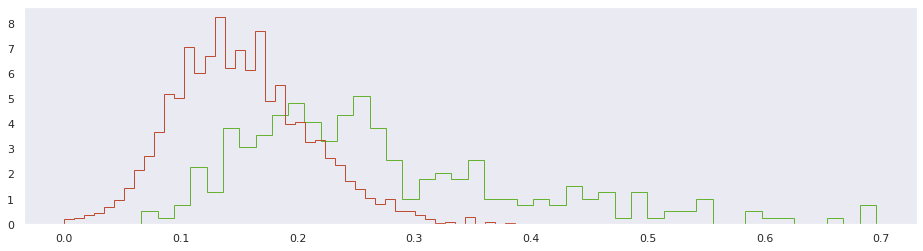

Size of genuine/imposter : 280,2880
Distribution for descriptor ORB, strategy GLOBAL


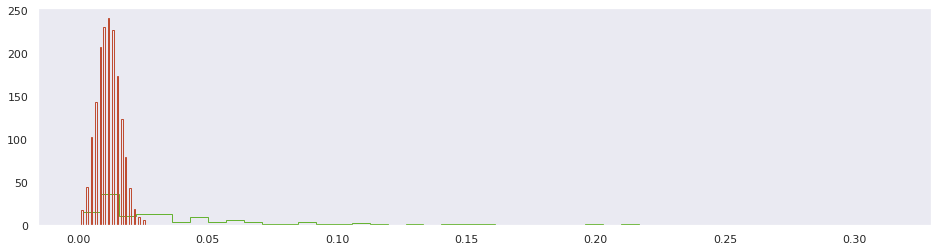

Size of genuine/imposter : 280,2880
Distribution for descriptor ORB, strategy COMPOSITE


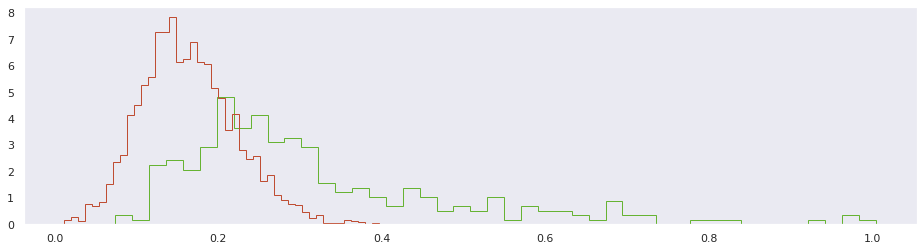

Size of genuine/imposter : 280,2880
Distribution for descriptor BRIEF, strategy LOCAL


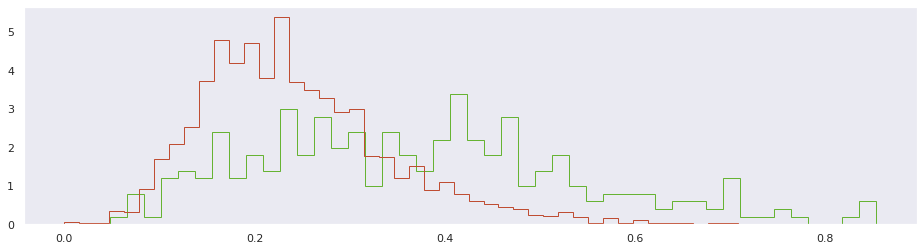

Size of genuine/imposter : 280,2880
Distribution for descriptor BRIEF, strategy GLOBAL


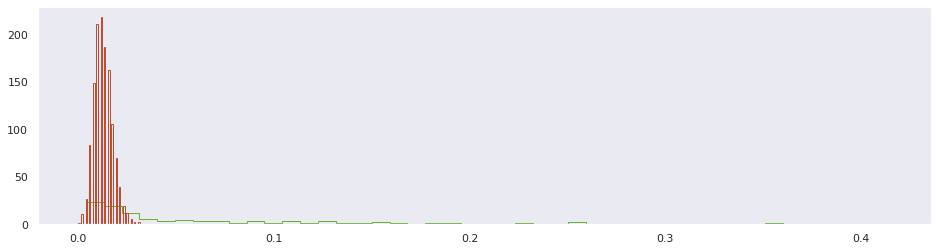

Size of genuine/imposter : 280,2880
Distribution for descriptor BRIEF, strategy COMPOSITE


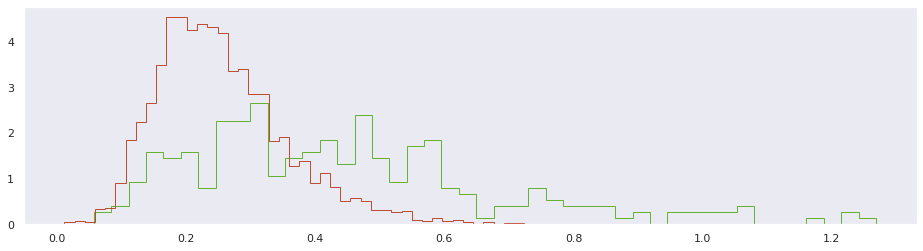

In [25]:
import os.path

# Fetch scores from disk and plot distributions
scores_dict = {}
for descriptor in ['ORB', 'BRIEF']:
  for (strategy, function) in [('LOCAL', get_score_local), ('GLOBAL', get_score_global), ('COMPOSITE', get_score_composite)]:
    matrix_file = "./fprdata/DB" + str(selected_database) + "_" + descriptor + '_' + strategy + "_fvcstyle.p"
    if os.path.isfile(matrix_file):
      pickle_file = open(matrix_file, "rb")
      s, g, i = pickle.load(pickle_file)
    else:
      s, g, i = calculate_similarity_matrix(images_enhanced, masks, descriptor=descriptor, score_function=function)
      pickle_file = open(matrix_file, "wb")
      pickle.dump((s,g,i), pickle_file)
    scores_dict[descriptor + '_' + strategy] = (s, g, i)
    print("Size of genuine/imposter : " + str(len(g)) + "," + str(len(i))) # Should be 360 and 2880
    print("Distribution for descriptor " + descriptor + ", strategy " + strategy)
    plot_distributions(g, i)

EER for ORB_LOCAL : ( 0.2569444444444444 )
AUC for ORB_LOCAL :  0.8294500248015875
EER for ORB_GLOBAL : ( 0.2725694444444444 )
AUC for ORB_GLOBAL :  0.7923375496031746
EER for ORB_COMPOSITE : ( 0.2326388888888889 )
AUC for ORB_COMPOSITE :  0.8471310763888888
EER for BRIEF_LOCAL : ( 0.32743055555555556 )
AUC for BRIEF_LOCAL :  0.7349609374999999
EER for BRIEF_GLOBAL : ( 0.3211805555555556 )
AUC for BRIEF_GLOBAL :  0.8097792658730159
EER for BRIEF_COMPOSITE : ( 0.3003472222222222 )
AUC for BRIEF_COMPOSITE :  0.7670213293650793


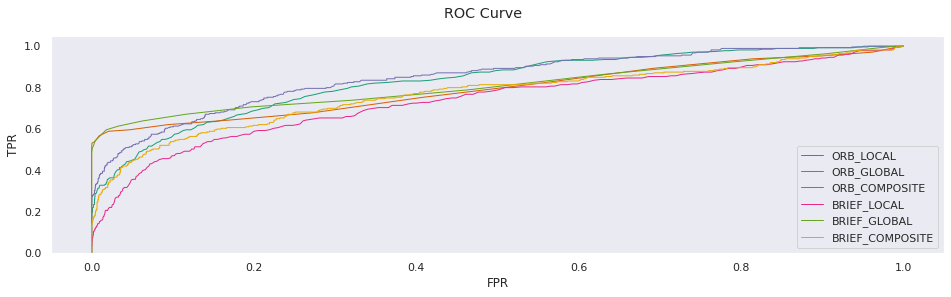

In [26]:
# Visualise the ROC curves
from sklearn.metrics import roc_auc_score
colors = plt.get_cmap("Dark2").colors
center_plots()
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
figure.suptitle('ROC Curve')
color_idx = 0
for strategy in scores_dict.keys():
  _, genuine_scores, imposter_scores = scores_dict[strategy]
  genuine_id = np.hstack((np.ones(len(genuine_scores)), np.zeros(len(imposter_scores))))
  scores = np.hstack((genuine_scores, imposter_scores))
  fpr, tpr, thresholds = roc_curve(genuine_id, scores)
  min_index = np.argmin(abs((1-tpr)-fpr))
  print("EER for " + strategy + " : (", fpr[min_index], ")") #, thresholds[min_index], fpr[min_index], ")")
  print("AUC for " + strategy + " : ", roc_auc_score(genuine_id, scores))
  axes.plot(fpr, tpr, color=colors[color_idx], lw=1, label=strategy) # np.random.rand(3,)
  color_idx = color_idx + 1 
axes.set(xlabel='FPR', ylabel='TPR', ylim=[0.0,1.05])
axes.legend()
plt.show()

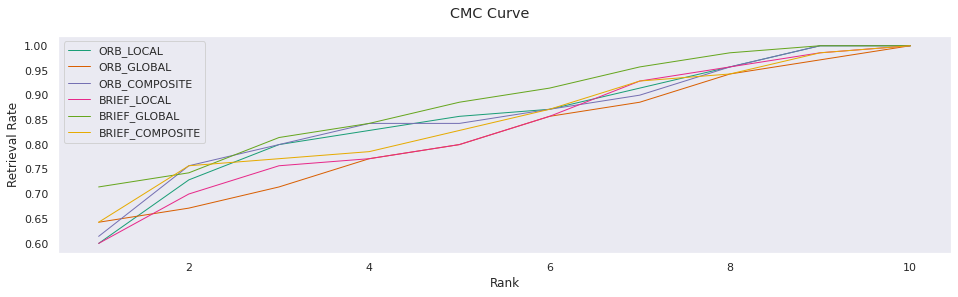

In [27]:
def CMC(similarity_matrix, nb_people=10, nb_samples=8):
  """
  Calculate the Cumulative Matching Characteristic curve.
  N.B. I consider the first picture for every person the 'template'.
    So I check for each non-template how it ranks that template.
  """
  def get_gallery(i):
    """Helper function to calculate the gallery."""
    return (i-(i%nb_samples)), [nb_samples * t for t in range(0,nb_people)]
    #return (i-(i%nb_samples)), [s for s in range(80) if s == template or s // 8 != i // 8]
  n_ranks = len(get_gallery(0)[1])
  cmc = [0] * n_ranks
  considered = 0
  for (i,row) in enumerate(similarity_matrix):
    if i % 8 > 0:
      considered = considered + 1
      template, gallery = get_gallery(i)
      template_scores = [row[t] for t in gallery]
      rank = sorted(template_scores, reverse=True).index(row[template])
      if rank < n_ranks:
        cmc[rank] += 1
  prev = 0
  for r in range(n_ranks):
    prev = cmc[r] + prev
    cmc[r] = prev / considered
  return cmc

# Visualise CMC plots
colors = plt.get_cmap("Dark2").colors
color_idx = 0
center_plots()
figure, axes = plt.subplots(ncols=1, figsize=(16,4))
figure.suptitle('CMC Curve')
for strategy in scores_dict.keys():
  matrix, _, _ = scores_dict[strategy]
  cmc = CMC(matrix)
  axes.plot(list(range(1,len(cmc)+1)), cmc, color=colors[color_idx], lw=1, label=strategy)
  color_idx = color_idx + 1
axes.set(xlabel='Rank', ylabel='Retrieval Rate')
axes.legend()
plt.show()

*Something to be noted is that in the first part of the assignment the gallery was taken to be the whole row. Normally the CMC is computed for a gallery (a probe is matched with the templates in the gallery and the rank is calculated this way). The gallery consists of different individuals. So I took the gallery to be the set of first pictures of every individual (10 in total). Then I matched all other pictures ('probes') with this gallery and plotted probabilities in terms of the ranks. This is based on Bolle's book 'Guide to Biometrics' when treating a 1:m biometric search engine.*

*Also in the case of face recognition a gallery (well, virtual gallery) and probe testing strategy is used where the gallery consists of different individuals. This is dealt with later.*

*In the end comparison with FVC 2000 is done on the basis of the EER which I calculated like they did.*

EER for BRIEF_COMPOSITE : ( 0.20721726190476192 )


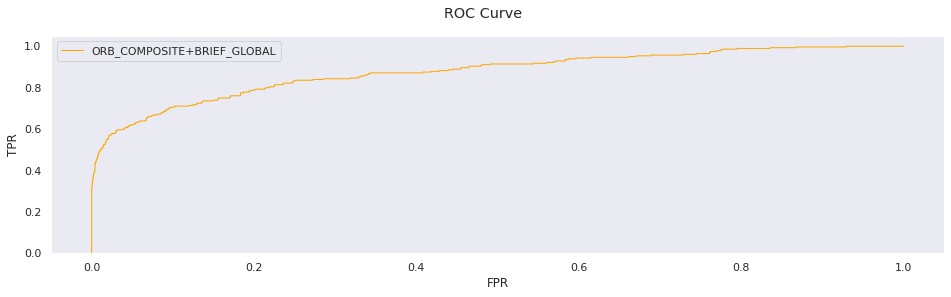

In [28]:
# Visualisation of ROC curve for ensemble of the two best (in the sense of EER) ones
center_plots()
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
figure.suptitle('ROC Curve')
_, genuine_scores_1, imposter_scores_1 = scores_dict['ORB_COMPOSITE']
_, genuine_scores_2, imposter_scores_2 = scores_dict['BRIEF_GLOBAL']
genuine_scores = [(a + b)/2 for (a,b) in zip(genuine_scores_1,genuine_scores_2)]
imposter_scores = [(a + b)/2 for (a,b) in zip(imposter_scores_1,imposter_scores_2)]
genuine_id = np.hstack((np.ones(len(genuine_scores)), np.zeros(len(imposter_scores))))
scores = np.hstack((genuine_scores, imposter_scores))
use_sklearn_roc = False
if use_sklearn_roc:
  fpr, tpr, thresholds = roc_curve(genuine_id, scores)
  min_index = np.argmin(abs((1-tpr)-fpr))
  print("EER for " + strategy + " : (", fpr[min_index], ")") #, thresholds[min_index], fpr[min_index], ")")
  print("AUC for " + strategy + " : ", roc_auc_score(genuine_id, scores))
else: # here I tested my implementation and it worked with the EER being almost the same
  fpr, tpr, thresholds, eer = full_roc(genuine_id, scores)
  print("EER for " + strategy + " : (", eer, ")")
axes.plot(fpr, tpr, color='orange', lw=1, label='ORB_COMPOSITE+BRIEF_GLOBAL') # np.random.rand(3,)
axes.set(xlabel='FPR', ylabel='TPR', ylim=[0.0,1.05])
axes.legend()
plt.show()

*These results are similar to those seen in the visualization and cannot compete particularly well with the results of the FVC competition. ORB appears to outperform BRIEF.*

#### Task 4 Discuss your results
    
* which parts are critical?
* given more time, how would you improve?
* compare your results to the results that are available [online](http://bias.csr.unibo.it/fvc2002/results.asp) 

*For now the results are not particularly satisfactory. The EER is amongst the worst in the competition. Not much of a surprise. The algorithms do outperform random-guess algorithms by a good deal which is a start.*

*All parts of the algorithm appear to be crucial, here are some comments for the various steps :*

*   *The enhancement : results got significantly better as I fixed a bug in the provided notebook which led some images to be poorly enhanced.*
*   *The keypoint detector and descriptor, obviously (as per the results overall). Retaining enough features (by tuning the corresponding parameter for the keypoint detectors) is important.*
*   *Though the enhancement is quite successful it looks like the matching is too weak to distinguish imposters from genuine scores properly.*

*In what follows I experiment with two other things : minutiae and the Poincaré index to try and improve the results. The idea is to find ridge endings, bifurcations, thworls, deltas, ... rather than hoping that SIFT/ORB/... does it 'by accident'.*

#### Minutiae

*A first, obvious experiment is to try using minutiae. I use the provided code for this. I did some tests where I described the minutiae with a SIFT or other descriptor and the results improved a bit in comparison to the other detector/descriptor strategies. But still it wasn't anywhere close satisfactory so I try an other approach next.*

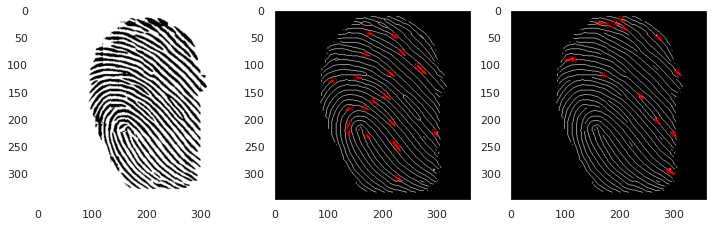

In [29]:
# Example
import fprmodules.minutiae_extraction as fme
(endings, bifurcations, skeleton) = fme.extractMinutiae(images_enhanced[0], masks[0])
clear_output()

# Visualise
center_plots(True)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
ax[0].imshow(images[0], cmap='gray')
# Display minutiae
annotated_endings = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2BGR)
for point in endings:
  angle = orientations[0][point[0]][point[1]]
  x =  int(round(point[1] + 10 * np.cos(angle)));
  y =  int(round(point[0] + 10 * np.sin(angle)));
  cv2.line(annotated_endings, (point[1],point[0]), (x,y), (255,0,0), thickness=2)
  cv2.circle(annotated_endings, tuple(point[::-1]), 5, (255,0,0))
ax[1].imshow(annotated_endings)
# Display bifurcations
annotated_bifurcations = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2BGR)
for point in bifurcations:
  angle = orientations[0][point[0]][point[1]]
  x =  int(round(point[1] + 10 * np.cos(angle)));
  y =  int(round(point[0] + 10 * np.sin(angle)));
  cv2.line(annotated_bifurcations, (point[1],point[0]), (x,y), (255,0,0), thickness=2)
  cv2.circle(annotated_bifurcations, tuple(point[::-1]), 5, (255,0,0))
ax[2].imshow(annotated_bifurcations)
plt.show()

*As can be seen the minutiae endings aren't perfect, there are some artifacts. What I do next is based on Jiang's and Yau's study [that can be found here](https://sci-hub.st/10.1109/ICPR.2000.906252).*

*They mention two techniques to do minutiae matching, local and global. The local technique is to find a translation - and orientation-invariant feature vector based on a minutia and its nearest neighbor which allows for direct matching with the feature vectors for some other image of a fingerprint.*

*This can then be improved upon by using a global technique.*

In [65]:
import math 
def get_minutiae_local_features(minutiae, orientations, strategy='jiang'):
  """
  Calculate local feature vectors for the given minutiae. Several strategies are possible.
  """
  def dfun(a,b):
    """Helper function for angular differences."""
    if (a-b) > -math.pi and (a-b) <= math.pi:
      return (a-b)
    elif (a-b) <= -math.pi:
      return 2 * math.pi + (a-b)
    elif (a-b) > math.pi:
      return 2 * math.pi - (a-b)
  nb = len(minutiae)
  assert nb == len(orientations)
  features = []
  if strategy == 'jiang':
    neighbors = [(i,min([(np.linalg.norm(minutiae[i]-minutiae[j]),j) for j in range(nb) if i != j])) for i in range(nb)]
    for (i,(dist,j)) in neighbors: # calculate local feature vector for each pair of neighbors
      minutia_i = minutiae[i]
      orientation_i = orientations[i]
      minutia_j = minutiae[j]
      orientation_j = orientations[j]
      features.append([dist,
                       dfun(math.atan((minutia_i[0]-minutia_j[0])/(minutia_i[1]-minutia_j[1])),orientation_i),
                       dfun(orientation_i,orientation_j)])
  else:
    pass
  return features

# Test algorithm (jiang strategy)
for (i,j) in [(0,1),(0,8)]:
  img1 = images_enhanced[i]
  img2 = images_enhanced[j]
  mask1 = masks[i]
  mask2 = masks[j]
  orientation1 = orientations[i]
  orientation2 = orientations[second_image]
  # Find endings, bifurcations and the orientations at these points
  (endings_src, bifurcations_src, _) = fme.extractMinutiae(img1, mask1)
  (endings_dest, bifurcations_dest, _) = fme.extractMinutiae(img2, mask2)
  orientations_src = [orientations[first_image][minutia[0]][minutia[1]] for minutia in endings_src]
  orientations_dest = [orientations[second_image][minutia[0]][minutia[1]] for minutia in endings_dest]
  # Get feature vectors
  feature_vectors_1 = np.asarray(get_minutiae_local_features(endings_src, orientations_src))
  feature_vectors_2 = np.asarray(get_minutiae_local_features(endings_dest, orientations_dest))
  distances = sorted([np.linalg.norm(f_1-f_2) for f_1 in feature_vectors_1 for f_2 in feature_vectors_2])
  print(distances)
  print(sum(distances))

/content/drive/My Drive/Development/Biometrics/fingerprint/fprmodules/minutiae_extraction/extractMinutiae.py:45: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  minutiaeTerm = skimage.measure.label(minutiaeTerm, 8);
/content/drive/My Drive/Development/Biometrics/fingerprint/fprmodules/minutiae_extraction/extractMinutiae.py:54: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  BifLabel = skimage.measure.label(minutiaeBif, 8);
/content/drive/My Drive/Development/Biometrics/fingerprint/fprmodules/minutiae_extraction/extractMinutiae.py:55: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  TermLabel = skimage.measure.label(minutiaeTerm, 8);


[0.27649458425979123, 0.5036635699206065, 0.5044698891906997, 0.5053969786055806, 0.5161376336642239, 0.5445040335930599, 0.5911449692430708, 0.5912815517382494, 0.5953424289577448, 0.5964750520975758, 0.8532575737836069, 0.8539751653116693, 1.2591041878977132, 1.2672091398992216, 1.2799780998460173, 1.2838768831683263, 1.2884999511511264, 1.2925082251345412, 1.2971845286527508, 1.2981275782253363, 1.3073165177189687, 1.3462473949974092, 1.357208205005472, 1.4407716937780823, 1.4440406637804217, 1.4451277367340873, 1.456894598721601, 1.4641090694525845, 1.467016706638242, 1.479663279158494, 1.4822388217763862, 1.4831137181809562, 1.5298277490082173, 1.6048798992219762, 1.616800377093749, 1.6491579781254728, 1.6512996637228587, 1.653752403977557, 1.707624187866912, 1.7280276137696748, 1.8024690617940888, 2.0497679425994764, 2.056720394582378, 2.105418433851984, 2.114073153891057, 2.1449207172520715, 2.1541778288741145, 2.2798732353335063, 2.3751550899530787, 2.4043402421975495, 2.426569

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in short_scalars


In [0]:
def get_minutiae(idx):
  """Get the minutiae for the image at the given index."""
  return fme.extractMinutiae(images_enhanced[idx], masks[idx])

# Calculate minutiae and save them to disk
people = 10
samples = 8
nb_images = people*samples

minutiae_file = "./fprdata/DB" + str(selected_database) + "_minutiae.p"
if os.path.isfile(minutiae_file):
  saved_pickle_file = open(minutiae_file, 'rb')
  minutiae = pickle.load(saved_pickle_file)
else:
  minutiae = [get_minutiae(i) for i in tqdm_notebook(range(nb_images))]
  tosave_pickle_file = open(minutiae_file, 'wb')
  pickle.dump(minutiae, tosave_pickle_file)

*An experiment can also be done with the Poincaré index.*

In [0]:
import math
import copy

def get_angle(left, right):
  angle = left - right
  if abs(angle) > 180:
    angle = -1 * np.sign(angle) * (360 - abs(angle))
  return angle

def poincare_index_at(i, j, angles, tolerance):
  # See handbook of fingerprint recognition for explanation
  # It's not difficult ; just sum of difference of angles over closed path around (i,j)
  cells = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
  deg_angles = [math.degrees(angles[i - k][j - l]) % 180 for k, l in cells]
  index = 0
  for k in range(0, 8):
    if abs(get_angle(deg_angles[k], deg_angles[k + 1])) > 90:
      deg_angles[k + 1] += 180
    index += get_angle(deg_angles[k], deg_angles[k + 1])
  if 180 - tolerance <= index and index <= 180 + tolerance:
    return "loop"
  if -180 - tolerance <= index and index <= -180 + tolerance:
    return "delta"
  if 360 - tolerance <= index and index <= 360 + tolerance:
    return "whorl"
  return "none"

def kernel_from_function(size, f):
    kernel = [[] for i in range(0, size)]
    for i in range(0, size):
        for j in range(0, size):
            kernel[i].append(f(i - size / 2, j - size / 2))
    return kernel

def gauss_kernel(size):
    return kernel_from_function(size, gauss)

def apply_to_each_pixel(pixels, f):
    for i in range(0, len(pixels)):
        for j in range(0, len(pixels[i])):
            pixels[i][j] = f(pixels[i][j])

def gauss(x, y):
    ssigma = 1.0
    return (1 / (2 * math.pi * ssigma)) * math.exp(-(x * x + y * y) / (2 * ssigma))

def apply_kernel_at(get_value, kernel, i, j):
    kernel_size = len(kernel)
    result = 0
    for k in range(0, kernel_size):
        for l in range(0, kernel_size):
            pixel = get_value(i + k - kernel_size / 2, j + l - kernel_size / 2)
            result += pixel * kernel[k][l]
    return result

def apply_kernel(pixels, kernel):
    apply_kernel_with_f(pixels, kernel, lambda old, new: new)

def apply_kernel_with_f(pixels, kernel, f):
    size = len(kernel)
    for i in range(size // 2, len(pixels) - size // 2):
        for j in range(size // 2, len(pixels[i]) - size // 2):
          pixels[i][j] = f(pixels[i][j], apply_kernel_at(lambda x, y: pixels[x][y], kernel, i, j))

def transpose(ls):
    return map(list, zip(*ls))

def calculate_angles(image, bs, f, g):
    (x, y) = (len(image),len(image[0]))
    ySobel = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    xSobel = [[ySobel[j][i] for j in range(3)] for i in range(3)]
    result = [[] for i in range(1, x, bs)]
    get_pixel = (lambda a,b: image[int(a)][int(b)])
    for i in range(1, x, bs):
        for j in range(1, y, bs):
            nominator = 0
            denominator = 0
            for k in range(i, min(i + bs , x - 1)):
                for l in range(j, min(j + bs, y - 1)):
                    Gx = apply_kernel_at(get_pixel, xSobel, k, l)
                    Gy = apply_kernel_at(get_pixel, ySobel, k, l)
                    nominator += f(Gx, Gy)
                    denominator += g(Gx, Gy)
            angle = (math.pi + math.atan2(nominator, denominator)) / 2
            result[(i - 1) // bs].append(angle)
    return result

def smooth_angles(angles):
    cos_angles = copy.deepcopy(angles)
    sin_angles = copy.deepcopy(angles)
    apply_to_each_pixel(cos_angles, lambda x: math.cos(2 * x))
    apply_to_each_pixel(sin_angles, lambda x: math.sin(2 * x))
    kernel = gauss_kernel(5)
    apply_kernel(cos_angles, kernel)
    apply_kernel(sin_angles, kernel)
    for i in range(0, len(cos_angles)):
        for j in range(0, len(cos_angles[i])):
            cos_angles[i][j] = (math.atan2(sin_angles[i][j], cos_angles[i][j])) / 2
    return cos_angles

def calculate_singularities(image, tolerance=1, bs=16):
  # Calculate angles
  f = lambda x, y: 2 * x * y
  g = lambda x, y: x ** 2 - y ** 2
  angles = calculate_angles(image, bs, f, g)
  # Smooth angles
  angles = smooth_angles(angles)
  # Calculate singularities
  singularities = []
  for i in range(1, len(angles) - 1):
    for j in range(1, len(angles[i]) - 1):
      singularity = poincare_index_at(i, j, angles, tolerance)
      if singularity != "none":
        singularities.append((singularity,i,j))
  return singularities

# Visualize example
# orientations has, for every image, an 'image' with every pixel representing an angle in radians
ax = plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
image = cv2.cvtColor(images[0], cv2.COLOR_GRAY2BGR)
colors = {"loop" : (150, 0, 0), "delta" : (0, 150, 0), "whorl": (0, 0, 150)}
for (ty,x,y) in calculate_singularities(images_enhanced[0]):
  cv2.circle(image, (x,y), 5, colors[ty])
ax.imshow(image)
plt.show()